In [29]:
from glob import glob
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import plotly.graph_objs as go
from scipy.interpolate import splprep,splev
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [30]:
def readExports(processParams):
    print('Importing mooring '+str(processParams.wbatParams.mooringNum))
    dfs = []
    for file in tqdm(glob(processParams.evParams.outputDir+'exports\\tracks\\'+'*(regions).csv'),desc='Reading regions'):
        dfs.append(pd.read_csv(file))
    dfR = pd.concat(dfs)
    dfR = dfR[dfR.Num_targets>=4]
    dfs = []
    for file in tqdm(glob(processParams.evParams.outputDir+'exports\\tracks\\'+'*(targets).csv'),desc='Reading targets'):
        dfs.append(pd.read_csv(file))
    dfT = pd.concat(dfs)
    cols = np.append(dfT.columns[0:18],['Ping_number']).tolist()
    dfT = dfT[cols].drop(columns=['Region_name', 'Region_class'])
    dfR = dfR.drop(columns=['Region_name', 'Region_class','Target_length_mean'])
    dfR = dfR[dfR.TS_max < -30]
    dfT = dfT[dfT.Region_ID.isin(dfR.Region_ID)]
    dfT['Target_true_depth'] = processParams.wbatParams.mooringDepth-0.8-dfT.Target_range
    return dfR, dfT

# Using Echoview terminology, so Major = X, Minor = Y
def targetSpline(df, processID, regionID):
    df = df[(df.Region_ID==regionID) & (df.Process_ID==processID)]
    tck, u  = splprep([df.Distance_major_axis, df.Distance_minor_axis,df.Target_true_depth],k=3)
    x_knots, y_knots, z_knots = splev(np.linspace(0,1,len(df.Distance_major_axis)-1), tck)
    return x_knots, y_knots, z_knots 
    
def trackPlot(df,processID, regionID, plotElements =['track_smoothed','track','track_direct','targets','track_linear']):
    # plotElements: list of elements to include:
    # targets: target locations
    # track: line between targets
    # track_smoothed: Cubic spline with equal resolution to the number of targets
    # track_direct: "flux" line from start to end target based on spline    
    x_knots, y_knots, z_knots = targetSpline(df, processID, regionID)
    track_smoothed = go.Scatter3d(x=x_knots, y=y_knots, z=z_knots,mode='lines',line=dict(color='#56B4E9', width=5),name='B-spline')
    
    track_direct = go.Scatter3d(x=[x_knots[i] for i in (0, -1)], y=[y_knots[i] for i in (0, -1)], z=[z_knots[i] for i in (0, -1)],mode='lines',name='Direct Path')

    dfCur = df[(df.Region_ID==regionID) & (df.Process_ID==processID)]
    targets=go.Scatter3d(x=dfCur.Distance_major_axis, y=dfCur.Distance_minor_axis, z=dfCur.Target_true_depth,mode='markers',
        marker=dict(size=6,color='black', colorscale='plasma',opacity=0.8,colorbar=dict(title='TS',thickness=30),showscale=False),name='Targets')
    track = go.Scatter3d(x=dfCur.Distance_major_axis, y=dfCur.Distance_minor_axis, z=dfCur.Target_true_depth,mode='lines',line=dict(color='darkblue', width=2),name='Target path')
        
     # This is the linear fit version of this, getting heading from the X/Y against ping number separately 
    x = dfCur.Ping_number
    X = sm.add_constant(x)
    y = dfCur.Distance_major_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMaj = predictions.to_numpy()

    y = dfCur.Distance_minor_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMin = predictions.to_numpy()

    y = dfCur.Target_true_depth
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dZ = predictions.to_numpy()

    z_knots = [dZ[0],dZ[-1]]
    x_knots = [dMaj[0],dMaj[-1]]
    y_knots = [dMin[0],dMin[-1]]
    track_linear = go.Scatter3d(x=x_knots, y=y_knots, z=z_knots,mode='lines',line=dict(color='#E69F00', width=5),name='Linear model')
    
    allElements = {'track_smoothed':track_smoothed,'track':track,'track_direct':track_direct,'targets':targets,'track_linear':track_linear}
    fig = go.Figure(data=[allElements[i] for i in plotElements])
    split = (np.ceil(np.max([dfCur.Distance_major_axis.max() - dfCur.Distance_major_axis.min(),dfCur.Distance_minor_axis.max() - dfCur.Distance_minor_axis.min(),dfCur.Target_true_depth.max() - dfCur.Target_true_depth.min()]))/2)+.25
    fig.update_layout(showlegend=True,scene = dict(xaxis_title='Major axis distance (m)',
                        yaxis_title='Minor axis distance (m)',
                        zaxis_title='Depth (m)'),
                        #xaxis = dict(nticks=4, range=[np.median(dfCur.Distance_major_axis)-split, np.median(dfCur.Distance_major_axis)+split]),
                        #yaxis = dict(nticks=4, range=[np.median(dfCur.Distance_minor_axis)-split, np.median(dfCur.Distance_minor_axis)+split]),
                        #zaxis = dict(nticks=4, range=[np.median(dfCur.Target_true_depth)-split, np.median(dfCur.Target_true_depth)+split])),
                        width=700,
                        margin=dict(r=20, b=10, l=10, t=10))

    fig.show()

    
def regionStats(dfR,dfT,processParams):
    x_knots, y_knots, z_knots = targetSpline(dfT, dfR.Process_ID, dfR.Region_ID)
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsS = np.hypot(d[:,0], d[:,1],d[:,2])
    a = []
    for i in range(len(x_knots)-1):
        a.append(direction_lookup(processParams,x_knots[i+1],x_knots[i],y_knots[i+1],y_knots[i]))
    tDirS = np.mean(a)

    # This is the 'direct' spline version of this
    x_knots = [x_knots[i] for i in (0, -1)]
    y_knots = [y_knots[i] for i in (0, -1)]
    z_knots = [z_knots[i] for i in (0, -1)]
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsD = np.hypot(d[:,0], d[:,1],d[:,2])
    tDirD = direction_lookup(processParams,x_knots[1],x_knots[0],y_knots[1],y_knots[0])
        
    # This is the linear fit version of this, getting heading from the X/Y plane
    dfCur = dfT[(dfT.Process_ID==dfR.Process_ID)&(dfT.Region_ID==dfR.Region_ID)]
    if dfCur.Distance_minor_axis.max()-dfCur.Distance_minor_axis.min() < dfCur.Distance_major_axis.max()-dfCur.Distance_major_axis.min():
        x = dfCur.Distance_major_axis
        X = sm.add_constant(x)
        y = dfCur.Distance_minor_axis
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        x_knots = [X.Distance_major_axis.to_numpy()[0],X.Distance_major_axis.to_numpy()[-1]]
        y_knots = [predictions.to_numpy()[0],predictions.to_numpy()[-1]]
        z_knots = [dfCur.Target_true_depth.values[0],dfCur.Target_true_depth.values[-1]]
    
    
    elif dfCur.Distance_minor_axis.max()-dfCur.Distance_minor_axis.min() > dfCur.Distance_major_axis.max()-dfCur.Distance_major_axis.min():
        x = dfCur.Distance_minor_axis
        X = sm.add_constant(x)
        y = dfCur.Distance_major_axis
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        y_knots = [X.Distance_minor_axis.to_numpy()[0],X.Distance_minor_axis.to_numpy()[-1]]
        x_knots = [predictions.to_numpy()[0],predictions.to_numpy()[-1]]
        z_knots = [dfCur.Target_true_depth.values[0],dfCur.Target_true_depth.values[-1]]
    
    tDirL = direction_lookup(processParams,x_knots[1],x_knots[0],y_knots[1],y_knots[0])
    
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsL = np.hypot(d[:,0], d[:,1],d[:,2])
    
    tSpeedS=segdistsS.sum()/((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())*.4)
    tSpeedD=segdistsD.sum()/((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())*.4)
    tSpeedL=segdistsL.sum()/((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())*.4)

    return tSpeedS, segdistsS.sum(), tDirS, tSpeedD, segdistsD.sum(), tDirD, tSpeedL, segdistsL.sum(), tDirL

def regionStats2(dfR,dfT,processParams):
    x_knots, y_knots, z_knots = targetSpline(dfT, dfR.Process_ID, dfR.Region_ID)
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsS = np.hypot(d[:,0], d[:,1],d[:,2])
    a = []
    for i in range(len(x_knots)-1):
        a.append(direction_lookup(processParams,x_knots[i+1],x_knots[i],y_knots[i+1],y_knots[i]))
    tDirS = np.mean(a)

    # This is the 'direct' spline version of this
    x_knots = [x_knots[i] for i in (0, -1)]
    y_knots = [y_knots[i] for i in (0, -1)]
    z_knots = [z_knots[i] for i in (0, -1)]
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsD = np.hypot(d[:,0], d[:,1],d[:,2])
    tDirD = direction_lookup(processParams,x_knots[1],x_knots[0],y_knots[1],y_knots[0])
        
    # This is the linear fit version of this, getting heading from the X/Y against ping number separately 
    dfCur = dfT[(dfT.Process_ID==dfR.Process_ID)&(dfT.Region_ID==dfR.Region_ID)]
    x = dfCur.Ping_number
    X = sm.add_constant(x)
    y = dfCur.Distance_major_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMaj = predictions.to_numpy()

    y = dfCur.Distance_minor_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMin = predictions.to_numpy()
    
    y = dfCur.Target_true_depth
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dZ = predictions.to_numpy()

    z_knots = [dZ[0],dZ[-1]]
    x_knots = [dMaj[0],dMaj[-1]]
    y_knots = [dMin[0],dMin[-1]]
    
    tDirL = direction_lookup(processParams,x_knots[1],x_knots[0],y_knots[1],y_knots[0])
    
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdistsL = np.hypot(d[:,0], d[:,1],d[:,2])
    
    tSpeedS=segdistsS.sum()/(((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())+1)*.4)
    tSpeedD=segdistsD.sum()/(((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())+1)*.4)
    tSpeedL=segdistsL.sum()/(((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())+1)*.4)

    return tSpeedS, segdistsS.sum(), tDirS, tSpeedD, segdistsD.sum(), tDirD, tSpeedL, segdistsL.sum(), tDirL

def direction_lookup(processParams,destination_x, origin_x, destination_y, origin_y):
    deltaX = destination_x - origin_x
    deltaY = destination_y - origin_y
    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180
    # Flip for the inversion due to upward facing Xducer
    degrees_temp = 360-degrees_temp
    # Correct for the Xducer direction
    degrees_temp = (degrees_temp + processParams.wbatParams.mooringCompassOffset-360)
    # Whats the magnetic declination at the site?
    degrees_temp = degrees_temp + processParams.wbatParams.mooringMagDec
    # Convert check if its negative and correct
    if degrees_temp > 360:
        degrees_final = degrees_temp-360
    else:
        degrees_final = degrees_temp
    return degrees_final

def splineDF(dfR, dfT, processParams):
    #compassCor = {1:335,2:208,4:250,5:197,6:293}
    speedS,distS,headS = [],[],[]
    speedD,distD,headD = [],[],[]
    speedL,distL,headL = [],[],[]
    for index,row in tqdm(dfR.iterrows(),total=len(dfR),desc='Calculating splines'):
        sS,dS,hS,sD,dD,hD,sL,dL,hL = regionStats2(row,dfT,processParams)
        speedD.append(sD)
        distD.append(dD)
        headD.append(hD)
        speedS.append(sS)
        distS.append(dS)
        headS.append(hS)
        speedL.append(sL)
        distL.append(dL)
        headL.append(hL)
    dfR['directSpeed'] = np.around(np.array(speedD),3)
    dfR['directDist'] = np.around(np.array(distD),3)
    dfR['directHead'] = np.around(np.array(headD),3)
    dfR['smoothedSpeed'] = np.around(np.array(speedS),3)
    dfR['smoothedDist'] = np.around(np.array(distS),3)
    dfR['smoothedHead'] = np.around(np.array(headS),3)
    dfR['linearSpeed'] = np.around(np.array(speedL),3)
    dfR['linearDist'] = np.around(np.array(distL),3)
    dfR['linearHead'] = np.around(np.array(headL),3)
    return dfR

In [103]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/Calibrations/FinalCalData/EK80Lobes70and38/C11_17_18_70kHz.xml')
root = tree.getroot()

In [104]:
a,b = [],[]
for i in range(len(root[0][3])-1):
    a.append(float(root[0][3][i+1][6].text))
    b.append(float(root[0][3][i+1][7].text))

Text(0.5, 0.98, 'EK80 Single Targets')

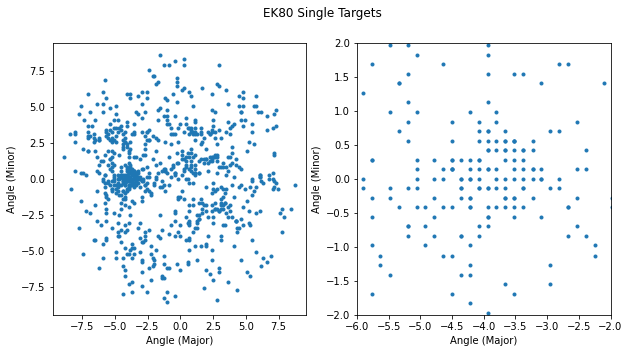

In [128]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(b,a,'.')
#plt.axis([-7.5,-4,-2.5,0])
plt.xlabel('Angle (Major)')
plt.ylabel('Angle (Minor)')

plt.subplot(122)
plt.plot(b,a,'.')
plt.axis([-6,-2,-2,2])
plt.xlabel('Angle (Major)')
plt.ylabel('Angle (Minor)')
plt.suptitle('EK80 Single Targets')

Text(0.5, 0.98, 'Echoview Single Targets')

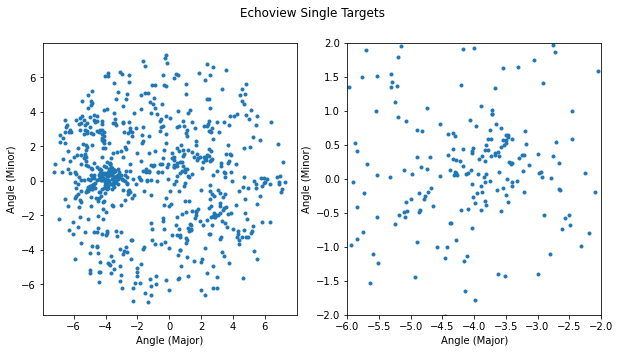

In [127]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(targs.Angle_major_axis, targs.Angle_minor_axis,'.')
#plt.axis([-7.5,-4,-2.5,0])
plt.xlabel('Angle (Major)')
plt.ylabel('Angle (Minor)')

plt.subplot(122)
plt.plot(targs.Angle_major_axis, targs.Angle_minor_axis,'.')
plt.axis([-6,-2,-2,2])
plt.xlabel('Angle (Major)')
plt.ylabel('Angle (Minor)')
plt.suptitle('Echoview Single Targets')

Text(0.5, 0, 'Angle (Along)')

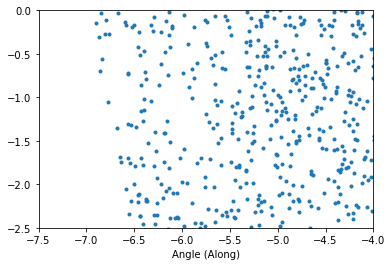

In [101]:
plt.plot(dfT[dfT.Process_ID==5644].Angle_minor_axis, dfT[dfT.Process_ID==5644].Angle_major_axis,'.')
#plt.hist(dfT.Angle_minor_axis,bins=5000);
plt.axis([-7.5,-4,-2.5,0])
plt.xlabel('Angle (Athwart)')
plt.xlabel('Angle (Along)')

In [31]:
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams1)
dfRSpline = splineDF(dfR, dfT, processParams1)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams1.wbatParams.mooringNum)+'_linear5.csv')

from mooringParams import paramsDAFT2 as processParams2 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams2)
dfRSpline = splineDF(dfR, dfT, processParams2)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams2.wbatParams.mooringNum)+'_linear5.csv')

from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams4)
dfRSpline = splineDF(dfR, dfT, processParams4)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams4.wbatParams.mooringNum)+'_linear5.csv')

from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams5)
dfRSpline = splineDF(dfR, dfT, processParams5)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams5.wbatParams.mooringNum)+'_linear5.csv')

from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams6)
dfRSpline = splineDF(dfR, dfT, processParams6)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams6.wbatParams.mooringNum)+'_linear5.csv')

Importing mooring 1



Importing mooring 2



Importing mooring 4



Importing mooring 5



Importing mooring 6


Importing mooring 1


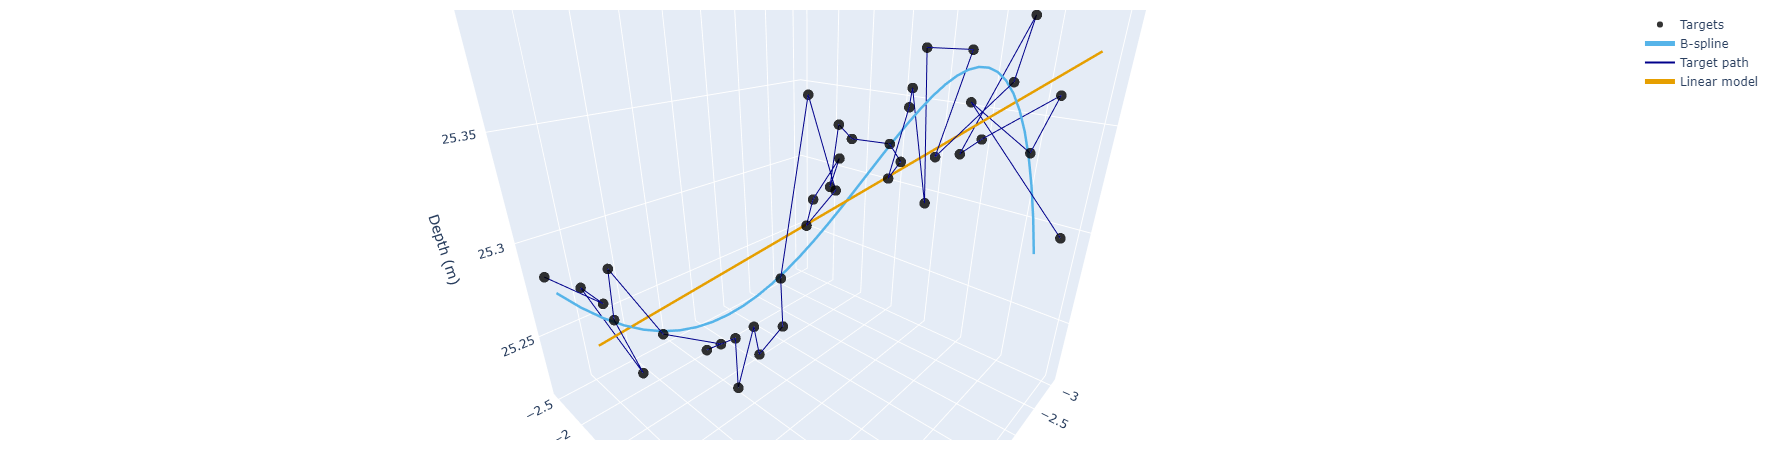

In [46]:
# FOR PRESENTATION ONLY
#from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams1)
dfR2 = dfR[(dfR.Date_S > 20180715)&(dfR.Date_S < 20180730)&(dfR.Num_targets > 30)]
i = 215 #214 173, 196
#dfT['Target_true_depth'] = 60-dfT.Target_true_depth
trackPlot(dfT,dfR2.iloc[i].Process_ID,dfR2.iloc[i].Region_ID,plotElements =['targets','track_smoothed','track','track_linear'])

In [ ]:
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams1)
i = 1
trackPlot(dfT,dfR2.iloc[i].Process_ID,dfR2.iloc[i].Region_ID)

# Assessing Echoview

In [5]:
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT2 as processParams2 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 


In [100]:
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT2 as processParams2 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 

dfRs,dfTs = [],[]
for p in [processParams1,processParams2,processParams4,processParams5,processParams6]:
    dfR, dfT = readExports(p)
    dfRs.append(dfR)
    dfTs.append(dfT)
dfR = pd.concat(dfRs)
dfT = pd.concat(dfTs)

Importing mooring 1



Importing mooring 2



Importing mooring 4



Importing mooring 5



Importing mooring 6


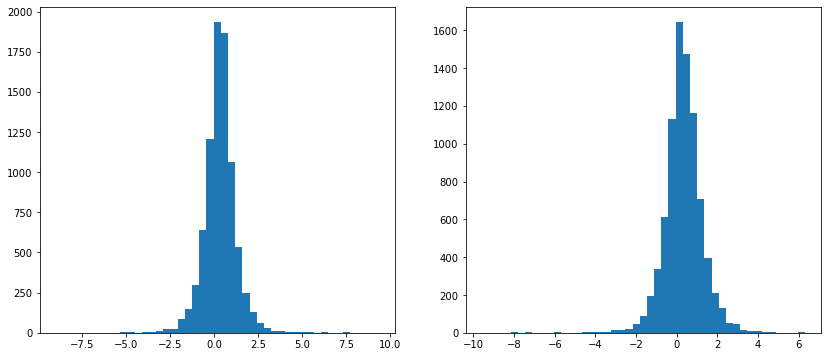

In [48]:
dfR2 = dfR.sample(1000)
dMin,dMaj,rid,pid = [],[],[],[]
for index, row in dfR2.iterrows():
    curTrack = dfT[(dfT.Process_ID==row.Process_ID)&(dfT.Region_ID==row.Region_ID)]
    for i in range(len(curTrack)-1):
        dMin.append(curTrack.iloc[i].Angle_minor_axis - curTrack.iloc[i+1].Angle_minor_axis)
        dMaj.append(curTrack.iloc[i].Angle_major_axis - curTrack.iloc[i+1].Angle_major_axis)
        if ((curTrack.iloc[i].Angle_minor_axis - curTrack.iloc[i+1].Angle_minor_axis)>4):
            rid.append(row.Region_ID)
            pid.append(row.Process_ID)
fig = plt.figure(figsize=(14,6))        
plt.subplot(121)
plt.hist(dMin,bins=45)
plt.subplot(122)
plt.hist(dMaj,bins=45);

Major Distance Mean: -0.004876342265885917
Minor Distance STD: 0.33118924573835573
Major Distance Mean: -0.022322221609985562
Minor Distance STD: 0.32422916934675733
Depth Mean: 0.0009948595536971893
Depth STD: 0.04500135466619002


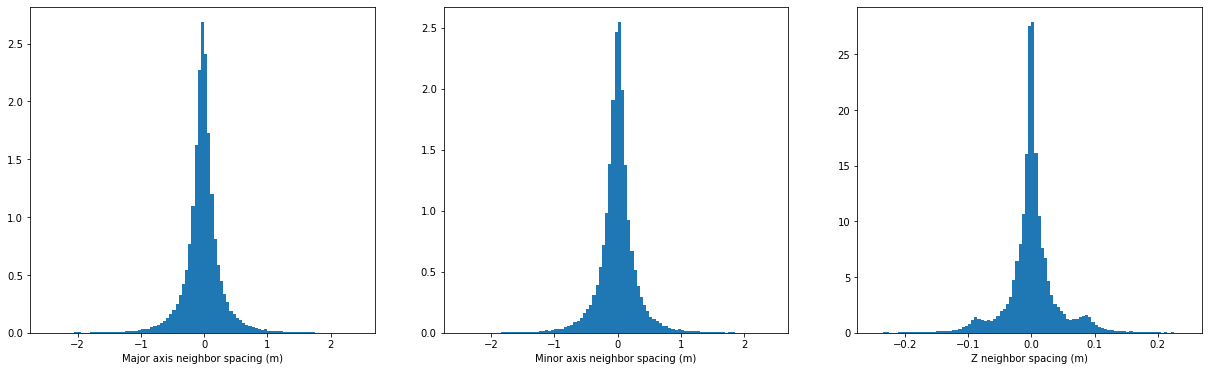

In [112]:
dfR2 = dfR.sample(n=10000) # Let's get the distances from target to target for a random sample of tracks in all 5 moorings
dMin,dMaj,dZ = [],[],[]
for index, row in dfR2.iterrows():
    curTrack = dfT[(dfT.Process_ID==row.Process_ID)&(dfT.Region_ID==row.Region_ID)]
    for i in range(len(curTrack)-1):
        dMin.append(curTrack.iloc[i+1].Distance_minor_axis - curTrack.iloc[i].Distance_minor_axis)
        dMaj.append(curTrack.iloc[i+1].Distance_major_axis - curTrack.iloc[i].Distance_major_axis)
        dZ.append(curTrack.iloc[i+1].Target_true_depth - curTrack.iloc[i].Target_true_depth)

fig = plt.figure(figsize=(21,6))        
plt.subplot(131)
plt.hist(dMin,bins=np.arange(-2.5,2.5,.05),density=True)
plt.xlabel('Major axis neighbor spacing (m)')
plt.subplot(132)
plt.hist(dMaj,bins=np.arange(-2.5,2.5,.05),density=True)
plt.xlabel('Minor axis neighbor spacing (m)')
plt.subplot(133)
plt.hist(dZ,bins=np.arange(-.25,.25,.005),density=True)
plt.xlabel('Z neighbor spacing (m)')
print('Major Distance Mean:',np.mean(dMaj))
print('Minor Distance STD:',np.std(dMaj))
print('Major Distance Mean:',np.mean(dMin))
print('Minor Distance STD:',np.std(dMin))
print('Depth Mean:',np.mean(dZ))
print('Depth STD:',np.std(dZ))

# Testing biases

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=True, tangent_tol=1e-9):
    """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.

    :param circle_center: The (x, y) location of the circle center
    :param circle_radius: The radius of the circle
    :param pt1: The (x, y) location of the first point of the segment
    :param pt2: The (x, y) location of the second point of the segment
    :param full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
    :param tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
    :return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

    Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr = (dx ** 2 + dy ** 2)**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        return []
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

In [ ]:
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams1)
from mooringParams import paramsDAFT2 as processParams2 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams2)
from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams4)
from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams5)
from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams6)


In [22]:
def calculateDistance(x1,y1,x2,y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def speedStat(dfCur, p=False):
    # Get the X pred
    x = dfCur.Ping_number
    X = sm.add_constant(x)
    y = dfCur.Distance_major_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMaj = predictions.to_numpy() 
    
    #Get the Y pred
    y = dfCur.Distance_minor_axis
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dMin = predictions.to_numpy()

    # Get the Z pred
    y = dfCur.Target_true_depth
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    dZ = predictions.to_numpy()

    # Fill in my 'knots' with the start and end locations
    z_knots = [dZ[0],dZ[-1]]
    x_knots = [dMaj[0],dMaj[-1]]
    y_knots = [dMin[0],dMin[-1]]
    
    coords = [j for j in zip(x_knots,y_knots,z_knots)] # reformat into [(x,y,z),(x,y,z)] coordinates for the end points of our model
    d = np.diff(coords, axis=0) # get the difference between each pair of positions
    segdistsL = np.hypot(d[:,0], d[:,1],d[:,2]) # take the hypotenuse to get total path length
    
    # speed is distance divided by time (total number of pings *0.6 s per ping)
    speedL = segdistsL.sum()/(((dfCur.Ping_number.max() - dfCur.Ping_number.min())+1)*.6) 
    
    # In a 2d (xy) plane, what are the points of intersection between our track (if it was continous) and the edge of the beam
    inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(coords[0][0],coords[0][1]),(coords[1][0],coords[1][1]))
    
    # Calculate the length of the complete segment that intersects the circle
    l = calculateDistance(inter[0][0], inter[0][1], inter[1][0], inter[1][1])
    prop = l/((np.tan(np.deg2rad(9))*dfCur.Target_range.mean())*2)
    
    if p:
        plt.plot(dfCur.Distance_major_axis,dfCur.Distance_minor_axis,'.',markersize=10)
        beam = plt.Circle((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),fill=False)
        plt.gca().add_patch(beam)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.plot([coords[0][0],coords[1][0]],[coords[0][1],coords[1][1]])


        plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
        plt.plot([0,0],[-np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),np.tan(np.deg2rad(9))*dfCur.Target_range.mean()],'k')

        plt.title('Range: '+str(np.round(np.mean(dfCur.Target_range),2))+' m, '+'BW: '+str(np.round(np.tan(np.deg2rad(9))*dfCur.Target_range.mean()*2,3))+' m')
        plt.xlabel('Major Distance (m)')
        plt.ylabel('Minor Distance (m)')
    
    return prop,speedL, np.mean(dfCur.Target_range)

def propBeam(dfR,dfT):
    props, speeds,ranges=[],[],[]
    for i in tqdm(range(len(dfR))):
        dfCur = dfT[(dfT.Process_ID==dfR.Process_ID.iloc[i])&(dfT.Region_ID==dfR.Region_ID.iloc[i])]
        l,s,r = speedStat(dfCur)
        props.append(l)
        speeds.append(s)
        ranges.append(r)
    return props,speeds,ranges, len(dfCur)

(0.969081491471356, 0.13589436674043548, 32.27566680000001)

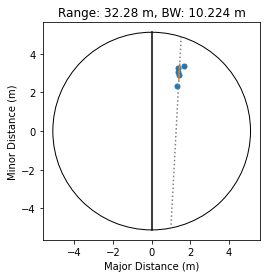

In [32]:
# Example for 1 track
i = 80
dfCur = dfT[(dfT.Process_ID==dfR.Process_ID.iloc[i])&(dfT.Region_ID==dfR.Region_ID.iloc[i])]
speedStat(dfCur,p=True)

In [23]:
ps,sps,rs,ls = [],[],[],[]
from mooringParams import paramsDAFT1 as processParams1 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams1)
prop,speed,r,l = propBeam(dfR,dfT)
ps.append(prop)
sps.append(speed)
rs.append(r)
ls.append(l)

from mooringParams import paramsDAFT2 as processParams2 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams2)
prop,speed,r,l = propBeam(dfR,dfT)
ps.append(prop)
sps.append(speed)
rs.append(r)
ls.append(l)

from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams4)
prop,speed,r,l = propBeam(dfR,dfT)
ps.append(prop)
sps.append(speed)
rs.append(r)
ls.append(l)

from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams5)
prop,speed,r,l = propBeam(dfR,dfT)
ps.append(prop)
sps.append(speed)
rs.append(r)
ls.append(l)

from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams6)
prop,speed,r,l = propBeam(dfR,dfT)
ps.append(prop)
sps.append(speed)
rs.append(r)
ls.append(l)

# merge it all and plot it
dfs = []
for ct in [0,1,2,3,4]:
    dfs.append(pd.DataFrame({'prop':np.array(ps[ct]),'speed':np.array(sps[ct]),'range':np.array(rs[ct]),'targets':np.array(ls[ct]),'m':ct+1}))
df = pd.concat(dfs)

Importing mooring 1



Importing mooring 2



Importing mooring 4



Importing mooring 5



Importing mooring 6


Text(0.5, 0, 'Proportion of Beamwidth')

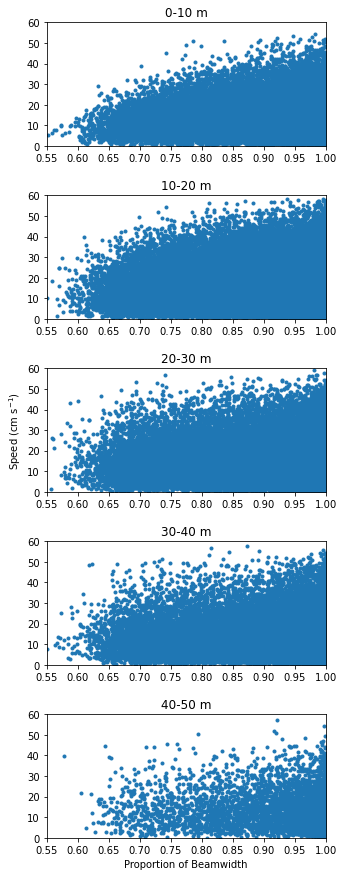

In [17]:
ct = 1
fig = plt.subplots(5,1,figsize=(5,15))
for r in [10, 20,30,40,50]:
    plt.subplot(5,1,ct)
    plt.plot(df[(df.range >r-10)&(df.range <r)].prop,df[(df.range >r-10)&(df.range <r)].speed*100,'.')
    plt.axis([0.55,1,0,60])
    if ct ==3:
        plt.ylabel('Speed (cm s$^{-1}$)')
    ct+=1
    plt.title(str(r-10)+'-'+str(r)+' m')
plt.subplots_adjust(hspace=.4)
plt.xlabel('Proportion of Beamwidth')

In [ ]:
ct = 1
fig = plt.subplots(5,1,figsize=(5,15))
for r in [10, 20,30,40,50]:
    plt.subplot(5,1,ct)
    plt.plot(df[(df.range >r-10)&(df.range <r)].prop,df[(df.range >r-10)&(df.range <r)].speed*100,'.')
    plt.axis([0.55,1,0,60])
    if ct ==3:
        plt.ylabel('Speed (cm s$^{-1}$)')
    ct+=1
    plt.title(str(r-10)+'-'+str(r)+' m')
plt.subplots_adjust(hspace=.4)
plt.xlabel('Proportion of Beamwidth')

0.6578656785425928

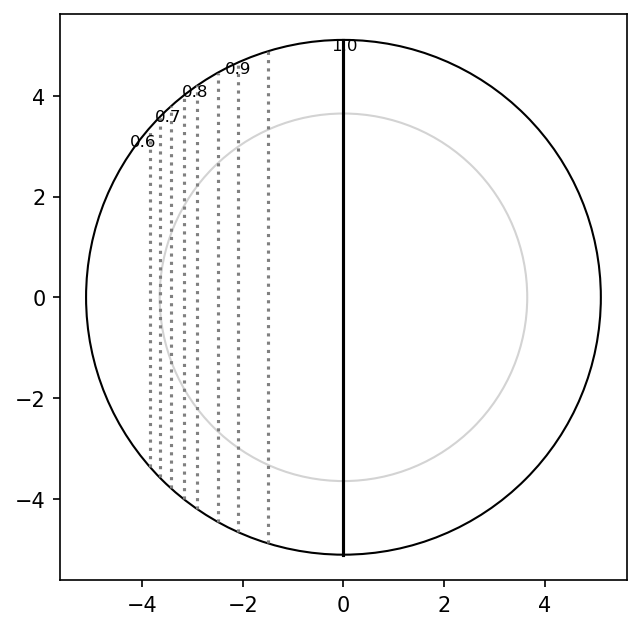

In [25]:

fig = plt.figure(figsize=(5,5),dpi=150)
beam = plt.Circle((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),fill=False)
plt.gca().add_patch(beam)
beam = plt.Circle((0,0),1.825*2,fill=False,color='lightgrey')
plt.gca().add_patch(beam)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0,0],[-np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),np.tan(np.deg2rad(9))*dfCur.Target_range.mean()],'k')

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-1.5,-1),(-1.5,1)) #95
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
plt.text(-.25,4.9,'1.0',fontsize=8)

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-2.1,-1),(-2.1,1)) # 90
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
plt.text(-2.35,4.45,'0.9',fontsize=8)

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-2.5,-1),(-2.5,1)) #85
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')


inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-2.9,-1),(-2.9,1)) #80
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
plt.text(-3.2,4.0,'0.8',fontsize=8)

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-3.17,-1),(-3.17,1)) #75
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-3.43,-1),(-3.43,1)) #70
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
plt.text(-3.75,3.5,'0.7',fontsize=8)

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-3.65,-1),(-3.65,1)) #65
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')

inter = circle_line_segment_intersection((0,0),np.tan(np.deg2rad(9))*dfCur.Target_range.mean(),(-3.85,-1),(-3.85,1)) #60
plt.plot([inter[0][0],inter[1][0]],[inter[0][1],inter[1][1]],':',color='grey')
plt.text(-4.25,3.0,'0.6',fontsize=8)


l = calculateDistance(inter[0][0], inter[0][1], inter[1][0], inter[1][1])
prop = l/((np.tan(np.deg2rad(9))*dfCur.Target_range.mean())*2)
prop